In [1]:
import base64
import sys
import os
import glob
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import scipy
DataDir = "C:/Users/jcornelison/Documents/GitHub/PROWLS-Control/Data/"
RunDir = "Frequency_Repeatability_Test/"

In [14]:
# Load the data
RunName = "freq_stab_test_spectra_18Apr2025"

file_name = DataDir+RunDir+"/Tables/"+RunName+"_*.csv"
files = glob.glob(file_name)
#freq_list = np.array([])
#amp_list = np.array([])
data_cut_freq = 120.9
data_cut_amp = 10
fnm = 'Desired Frequency (GHz)'
vnm = 'Vlockin (microvolts)'
tnm = 'Time'
for fileidx,file in enumerate(files):
    df = pd.read_csv(file)
    fidx = df[fnm] < data_cut_freq
    if np.max(df[vnm][fidx]) < data_cut_amp and np.max(df[vnm]) < 40:
        freq = df[fnm].values
        amp = df[vnm].values
        meastime = df[tnm].values
        if '_rev_' in file:
            freq = freq[::-1]
            amp = amp[::-1]
        if fileidx == 0:
            freq_list = [freq]
            amp_list = [amp]
            time_list = [np.median(meastime)]
        else:
            freq_list = np.concatenate((freq_list,[freq]),axis=0)
            amp_list = np.concatenate((amp_list,[amp]),axis=0)
            #time_list = np.concatenate((time_list,[meastime]),axis=0)
            time_list.append(np.median(meastime))
    else:
        continue

time_list = np.array(time_list)

In [23]:
# Function to compute shift of a single spectrum
def fit_shift(spectrum, reference, freq):
    interp_spectrum = interp1d(freq, spectrum, kind='cubic', fill_value="extrapolate")

    def cost(parm):
        shift = parm[0]
        bg = parm[1]
        amp = parm[2]
        shifted_freq = freq + shift
        shifted_spectrum = (interp_spectrum(shifted_freq)-bg)*amp+bg
        fidx = (freq<121.3)  & (freq>120.85)
        return np.sum((shifted_spectrum[fidx] - reference[fidx]) ** 2)

    result = minimize(cost, x0=[0,0,1])
    return result.x

def shift_spec(freq,spec,shift):
    interp_spectrum = interp1d(freq,spec, kind='cubic', fill_value="extrapolate")
    return interp_spectrum(freq+shift)


measured_shifts = [fit_shift(curve, amp_list[0], freq_list[0]) for curve in amp_list]


In [26]:
shifts = [p[0] for p in measured_shifts]
bgs = [p[1] for p in measured_shifts]
amps = [p[2] for p in measured_shifts]

def apply_spec_corr(freq,specs,parms):
    corr_specs = []
    for specidx,spec in enumerate(specs):
        corr_specs.append((shift_spec(freq,spec,parms[specidx][0])-parms[specidx][1])*parms[specidx][2]+parms[specidx][1])

    return corr_specs

corr_specs = apply_spec_corr(freq_list[0],amp_list,measured_shifts)

In [ ]:
corr_specs

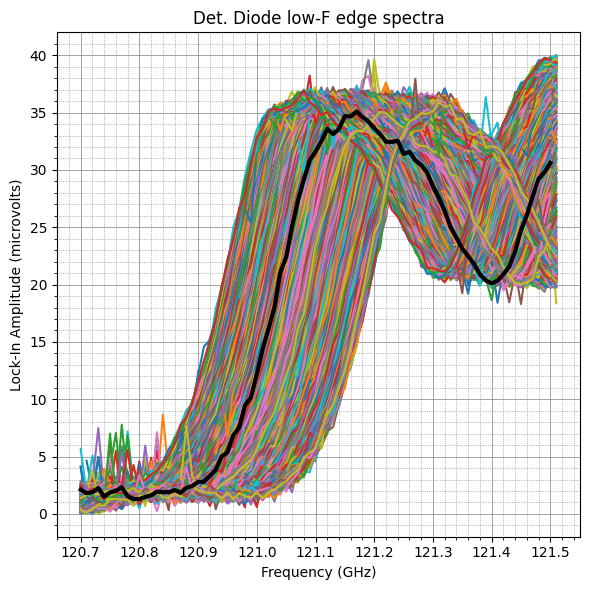

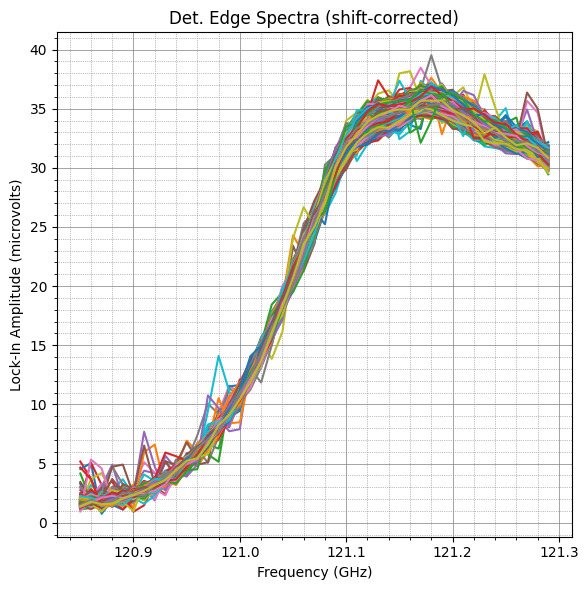

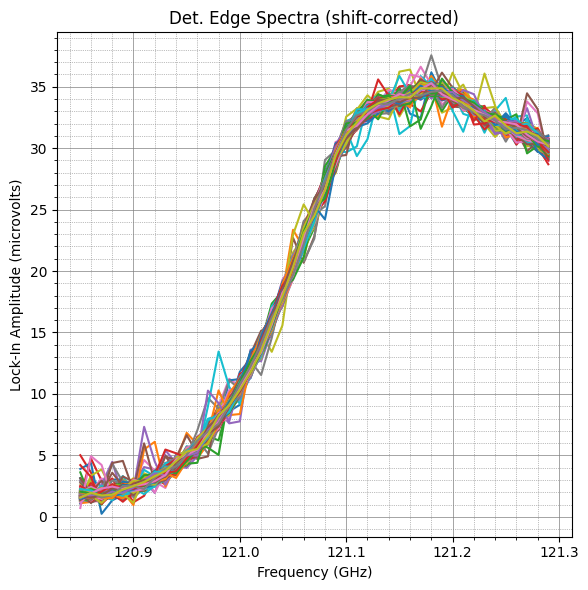

In [29]:
plt.figure(1,figsize = (6, 6))
for measidx,meas in enumerate(amp_list):
    freq = freq_list[measidx]
    amp = meas
    plt.plot(freq,amp)


plt.plot(freq,amp_list[0],'k',linewidth=3)    
plt.title('Det. Diode low-F edge spectra')
plt.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.ylabel('Lock-In Amplitude (microvolts)')
plt.xlabel('Frequency (GHz)')
plt.tight_layout()
plt.savefig('toptica_freq_stab_curves.png',dpi=300)
plt.show()

fidx = (freq_list[0]<121.3) & (freq_list[0]>120.85)
plt.figure(4,figsize = (6, 6))
for measidx,meas in enumerate(amp_list):
    #plt.subplot(2,1,1)
    plt.plot(freq_list[0][fidx],shift_spec(freq_list[0],meas,measured_shifts[measidx][0])[fidx])

    #plt.subplot(2,1,2)
    #plt.plot(freq_list[0][fidx][0:-1],np.diff(shift_spec(freq_list[0],meas,measured_shifts[measidx])[fidx]))


plt.title('Det. Edge Spectra (shift-corrected)')
plt.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.ylabel('Lock-In Amplitude (microvolts)')
plt.xlabel('Frequency (GHz)')
plt.tight_layout()
plt.savefig('toptica_freq_stab_curves_corrected.png',dpi=300)
plt.show()


fidx = (freq_list[0]<121.3) & (freq_list[0]>120.85)
plt.figure(24,figsize = (6, 6))
for measidx,meas in enumerate(amp_list):
    #plt.subplot(2,1,1)
    plt.plot(freq_list[0][fidx],corr_specs[measidx][fidx])

    #plt.subplot(2,1,2)
    #plt.plot(freq_list[0][fidx][0:-1],np.diff(shift_spec(freq_list[0],meas,measured_shifts[measidx])[fidx]))


plt.title('Det. Edge Spectra (shift-corrected)')
plt.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.ylabel('Lock-In Amplitude (microvolts)')
plt.xlabel('Frequency (GHz)')
plt.tight_layout()
#plt.savefig('toptica_freq_stab_curves_corrected.png',dpi=300)
plt.show()




# plt.figure(5)
# plt.hist(np.array(measured_shifts)*1000)
# plt.grid(True)
# plt.xlabel('Frequency Shift (MHz)')
# plt.show()

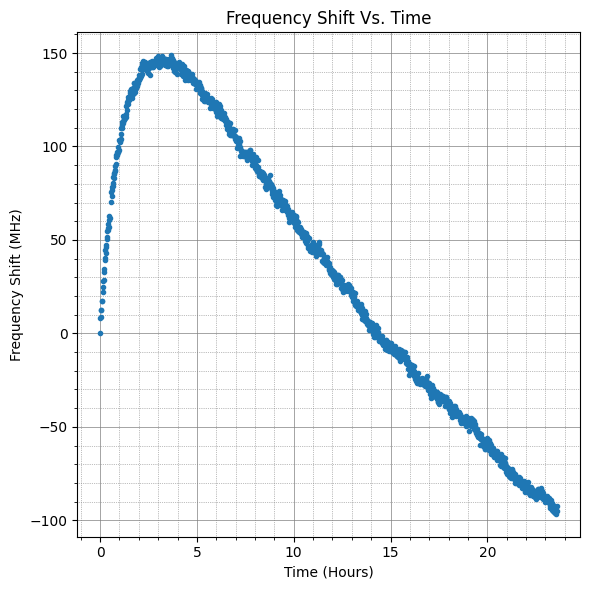

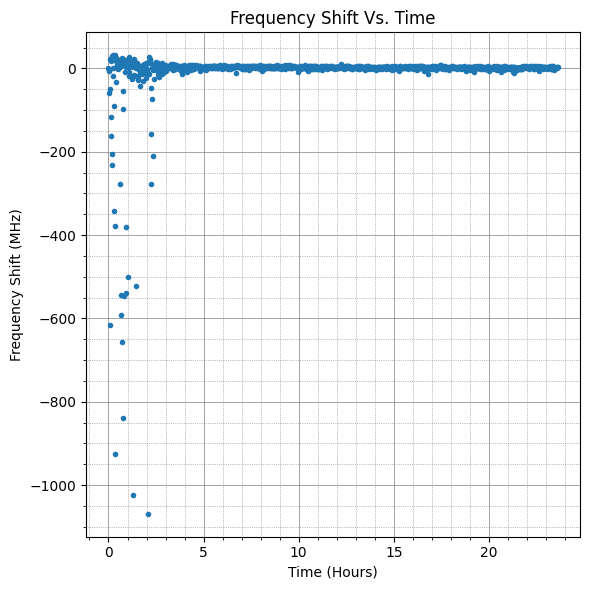

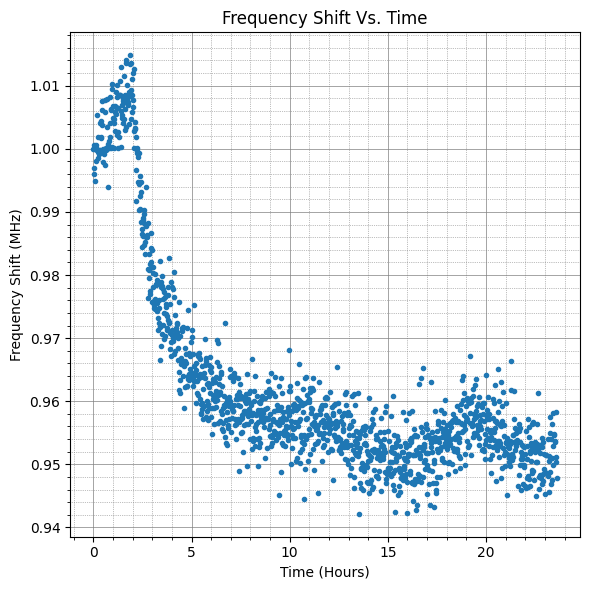

In [30]:
plt.figure(6,figsize=(6,6))
plt.plot((time_list-time_list[0])/3600,np.array(shifts)*1000,'.')

plt.title('Frequency Shift Vs. Time')
plt.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.ylabel('Frequency Shift (MHz)')
plt.xlabel('Time (Hours)')
plt.tight_layout()
plt.savefig('toptica_freq_shift.png',dpi=300)
plt.show()

plt.figure(7,figsize=(6,6))
plt.plot((time_list-time_list[0])/3600,np.array(bgs),'.')

plt.title('Frequency Shift Vs. Time')
plt.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.ylabel('Frequency Shift (MHz)')
plt.xlabel('Time (Hours)')
plt.tight_layout()
#plt.savefig('toptica_freq_shift.png',dpi=300)
plt.show()

plt.figure(8,figsize=(6,6))
plt.plot((time_list-time_list[0])/3600,np.array(amps),'.')

plt.title('Frequency Shift Vs. Time')
plt.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.ylabel('Frequency Shift (MHz)')
plt.xlabel('Time (Hours)')
plt.tight_layout()
#plt.savefig('toptica_freq_shift.png',dpi=300)
plt.show()

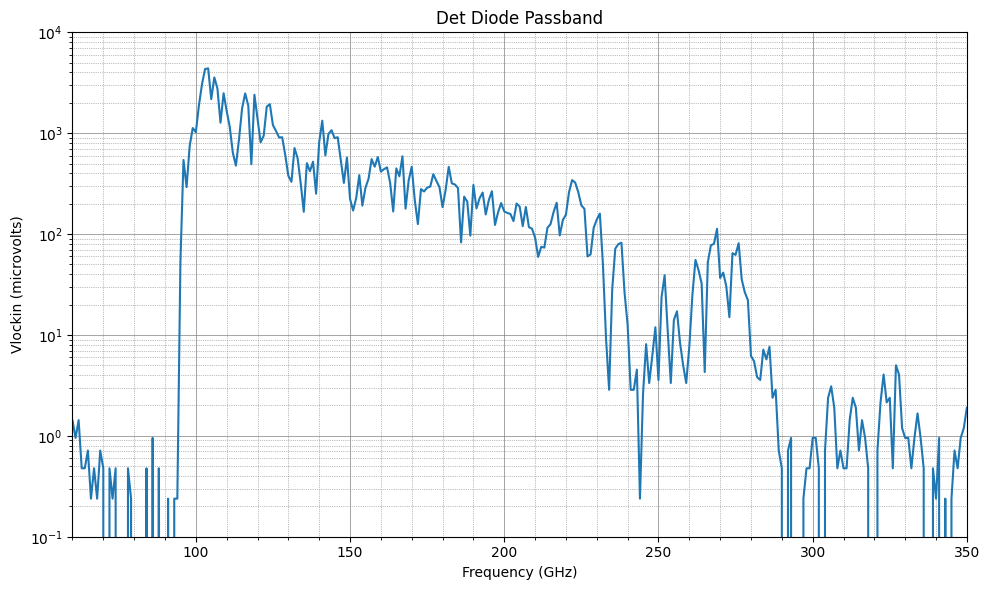

In [16]:
# Full Spectra plot
filename = 'C:/Users/jcornelison/Documents/GitHub/PROWLS-Control/Data/Material_Test//Tables/full_spectra_window_baseline5.csv'
df = pd.read_csv(filename)

plt.figure(10,figsize = (10, 6))
plt.plot(df['Desired Frequency (GHz)']-25, df['Vlockin (microvolts)'])
plt.yscale('log')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Vlockin (microvolts)')
plt.title('Det Diode Passband')
plt.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.ylim((1e-1,1e4))
plt.xlim((60,350))
#save to png
plt.tight_layout()
plt.savefig('det_diode_passband_high_power.png',dpi=300)
plt.show()



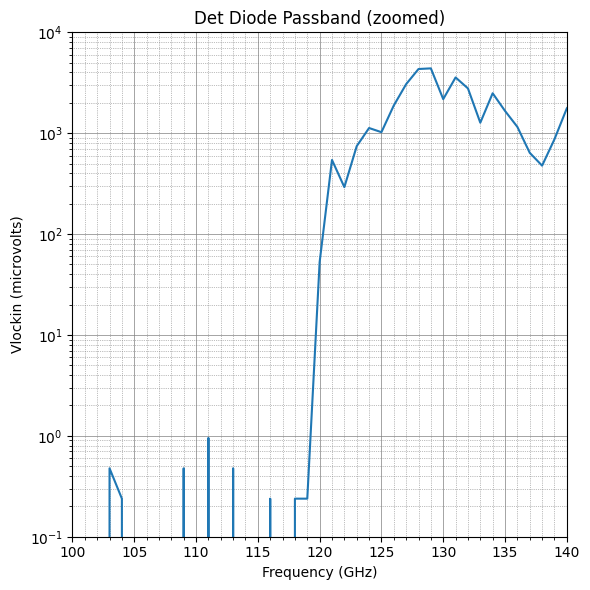

In [20]:
# Full Spectra plot
filename = 'C:/Users/jcornelison/Documents/GitHub/PROWLS-Control/Data/Material_Test//Tables/full_spectra_window_baseline5.csv'
df = pd.read_csv(filename)

plt.figure(10,figsize = (6, 6))
plt.plot(df['Desired Frequency (GHz)'], df['Vlockin (microvolts)'])
plt.yscale('log')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Vlockin (microvolts)')
plt.title('Det Diode Passband (zoomed)')
plt.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.ylim((1e-1,1e4))
plt.xlim((100,140))
#save to png
plt.tight_layout()
plt.savefig('det_diode_passband_high_power_zoomed.png',dpi=300)
plt.show()



In [ ]:
# Quick plot of Temp dependence

csv_file = 'C:/Users/jcornelison/Documents/GitHub/PROWLS-Control/Data/Temp_Dependence_with_heater/Tables/mirror_alignment_2024dec17.csv'
df = pd.read_csv(filename)


